# Business Problem
- The need for Customer Segmentation with RFM Analysis with e-commerce site data.

# Data Story
- The dataset has information on 100,000 orders made from 2016 to 2018 across multiple marketplaces in Brazil. Its features allow viewing an order from multiple dimensions: order number, customer number, total price paid, and date. The dataset consists of information derived from customers' past shopping behavior.
# Variables
- **Order_id:** Order number
- **Customer_unique_id:** Customer number
- **Price:** Total price paid by the customer
- **Order_purchase_timestamp:** Date of the customer purchase

In [1]:
# import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

warnings.simplefilter(action="ignore")

In [2]:
# Adjusting Row Column Settings
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

In [3]:
# Loading the Data Set
df = pd.read_csv("/kaggle/input/order-customerrfm/order_customer.csv")

In [4]:
df.head()

,order_id,customer_unique_id,order_purchase_timestamp,price
0,00e7ee1b050b8499577073aeb2a297a1,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,124.99
1,29150127e6685892b6eab3eec79f59c7,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,289.00
2,b2059ed67ce144a36e2aa97d2c9e9ad2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,139.94
3,951670f92359f4fe4a63112aa7306eba,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,149.94
4,6b7d50bd145f6fc7f33cebabd7e49d0f,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,230.00


In [5]:
# Preliminary examination of the data set
def check_df(dataframe, head=5):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('##################### Tail #####################')
    print(dataframe.tail(head))
    print('##################### NA #####################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles #####################')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(112650, 4)
##################### Types #####################
order_id                     object
customer_unique_id           object
order_purchase_timestamp     object
price                       float64
dtype: object
##################### Head #####################
                           order_id                customer_unique_id  \
0  00e7ee1b050b8499577073aeb2a297a1  861eff4711a542e4b93843c6dd7febb0   
1  29150127e6685892b6eab3eec79f59c7  290c77bc529b7ac935b93aa66c333dc3   
2  b2059ed67ce144a36e2aa97d2c9e9ad2  060e732b5b29e8181a18229c7b0b2b5e   
3  951670f92359f4fe4a63112aa7306eba  259dac757896d24d7702b9acbbff3f3c   
4  6b7d50bd145f6fc7f33cebabd7e49d0f  345ecd01c38d18a9036ed96c73b8d066   

  order_purchase_timestamp  price  
0      2017-05-16 15:05:35 124.99  
1      2018-01-12 20:48:24 289.00  
2      2018-05-19 16:07:45 139.94  
3      2018-03-13 16:06:38 149.94  
4      2018-07-29 09:51:30 230.00  
##################### Tail

In [6]:
# Examination of numerical and categorical variables

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.
    Parameters
    ------
         dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables
    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 112650
Variables: 4
cat_cols: 0
num_cols: 1
cat_but_car: 3
num_but_cat: 0


In [7]:
# Data type conversion
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  112650 non-null  object        
 1   customer_unique_id        112650 non-null  object        
 2   order_purchase_timestamp  112650 non-null  datetime64[ns]
 3   price                     112650 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.4+ MB


In [9]:
# Present Date (date of analysis)
today_date = dt.datetime(2018, 9, 5)

In [10]:
df["order_purchase_timestamp"].max()

Timestamp('2018-09-03 09:06:57')

In [11]:
# Calculating RFM Metrics
rfm = df.groupby("customer_unique_id").agg({"order_purchase_timestamp": lambda order_purchase_timestamp: (today_date - order_purchase_timestamp.max()).days,
                                            "order_id": lambda order_id: order_id.nunique(),
                                            "price": lambda price: price.sum()
                                            })

In [12]:
rfm.head()

,order_purchase_timestamp,order_id,price
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90
0000f46a3911fa3c0805444483337064,543,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99
0004aac84e0df4da2b147fca70cf8255,294,1,180.00


In [13]:
# Changing column names
rfm.columns = ['recency', 'frequency', 'monetary']

In [14]:
rfm.head()

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90
0000f46a3911fa3c0805444483337064,543,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99
0004aac84e0df4da2b147fca70cf8255,294,1,180.00


# Calculating RFM Scores (Recency_Score, Frequency_Score, Monetary_Score)

In [15]:
# Calculating Recency_Score
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

In [16]:
rfm.head()

,recency,frequency,monetary,recency_score
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,4
0000f46a3911fa3c0805444483337064,543,1,69.00,1
0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2
0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2


In [17]:
# Calculating Frequency_Score
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

In [18]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,4,1
0000f46a3911fa3c0805444483337064,543,1,69.00,1,1
0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2,1
0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2,1


In [19]:
# Calculating Monetary_Score
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

In [20]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,4,1,1
0000f46a3911fa3c0805444483337064,543,1,69.00,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2,1,1
0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2,1,5


In [21]:
# Creating RFM_SSCORE VARIABLE
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

In [22]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,41
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,4,1,1,41
0000f46a3911fa3c0805444483337064,543,1,69.00,1,1,2,11
0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2,1,1,21
0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2,1,5,21


In [23]:
# printing scores to csv
# rfm.to_csv("rfm.csv")

# Creating & Analysing RFM Segments

![](https://miro.medium.com/max/617/1*oUKMc3gk53hccFX4YNeu1g.png)

* **Champions** are the best customers, who bought most recently, most often, and are heavy spenders. Reward these customers. They can be the first to buy new products

* **Potential Loyalists** are the recent customers with average frequency and who spent a good amount. You can make them your Loyalists or Champions by offering membership or loyalty programs or recommending related products to them.

* **New Customers** are the customers who have a high overall RFM score but are not frequent shoppers. Special offers can be provided to increase their visits

* **At Risk Customers** are the customers who purchased often and spent big amounts, but haven’t purchased recently. Personalized deals and product/service recommendations can help reactivate them

* **Can’t Lose Them** are the customers who used to visit and purchase quite often, but haven’t been visiting recently. Get them to revisit with relevant promotions and conduct surveys to find out what went wrong and not lose them to a competitor.

In [24]:
# Creation of a segment map
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [25]:
# creating segment variable
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

In [26]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,41,promising
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,4,1,1,41,promising
0000f46a3911fa3c0805444483337064,543,1,69.00,1,1,2,11,hibernating
0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2,1,1,21,hibernating
0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2,1,5,21,hibernating


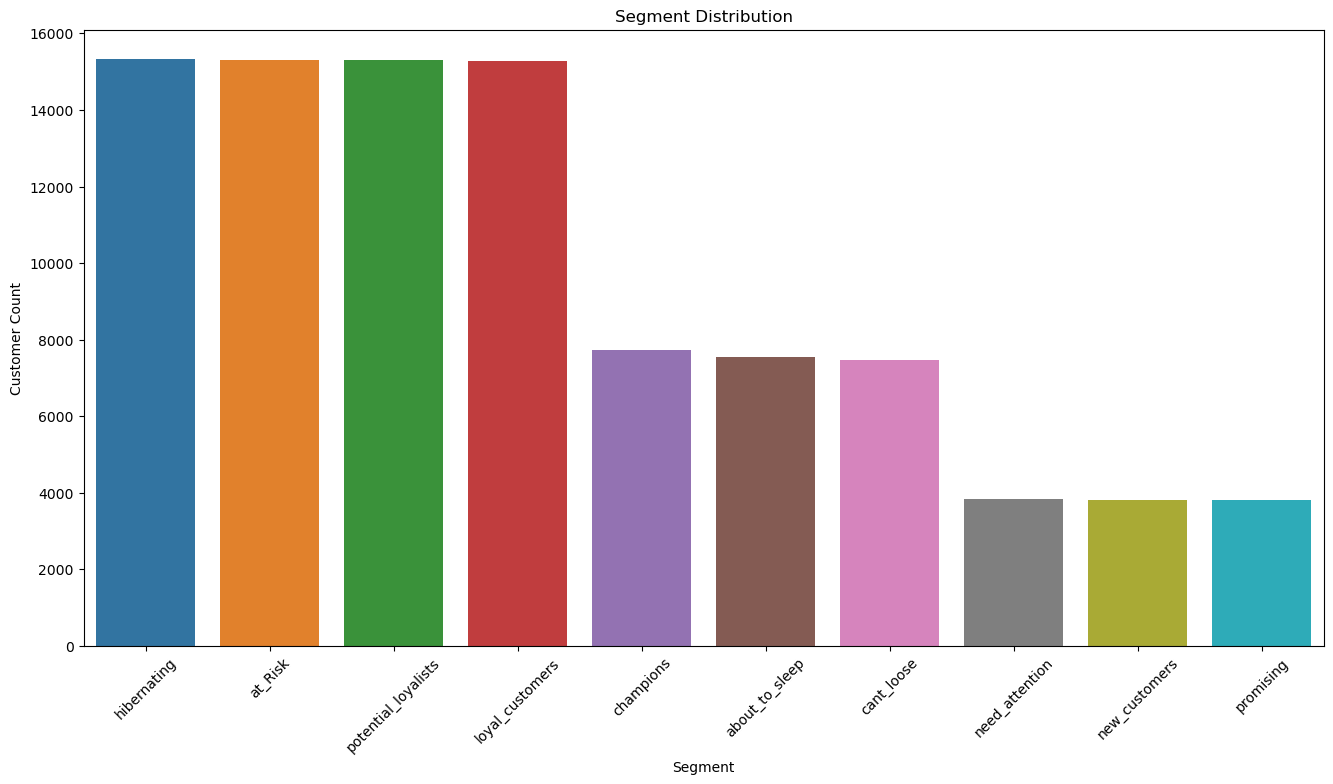

In [27]:
# Segment Distribution
segment_counts = rfm['segment'].value_counts()
plt.figure(figsize=(16, 8))
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title('Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)
plt.show()

In [28]:
# Segment Analysis
fig = px.scatter(rfm, x='recency', y='frequency', color='segment', title='RFM Segments')
fig.show()


In [29]:
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency        frequency        monetary       
                       mean  count      mean  count     mean  count
segment                                                            
about_to_sleep       226.41   7544      1.00   7544   133.30   7544
at_Risk              401.80  15310      1.00  15310   139.30  15310
cant_loose           401.10   7456      1.15   7456   156.61   7456
champions             51.52   7733      1.10   7733   150.98   7733
hibernating          402.47  15329      1.00  15329   141.30  15329
loyal_customers      184.86  15282      1.09  15282   146.12  15282
need_attention       226.19   3838      1.00   3838   126.73   3838
new_customers         51.93   3821      1.00   3821   136.64   3821
potential_loyalists   96.60  15299      1.00  15299   141.59  15299
promising            142.54   3808      1.00   3808   142.96   3808